<a href="https://colab.research.google.com/github/Carlo1911/deeplearning/blob/master/Estilo_focalizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transferencia de estilo focalizado



## Segmentación de instancias

Para esta tarea, se empleará la arquitectura Mask R-CNN.

El modelo Mask R-CNN aborda uno de los retos más difíciles de la visión por ordenador: la segmentación de imágenes. La segmentación de la imagen es la tarea de detectar y distinguir múltiples objetos dentro de una sola imagen. En particular, la Mask R-CNN realiza una "segmentación de instancia", lo que significa que a diferentes instancias del mismo tipo de objeto en la imagen de entrada, por ejemplo, un automóvil, se les deben asignar etiquetas distintas.

## Descarga el código fuente
Una implementación de Mask R-CNN se puede encontrar en https://github.com/tensorflow/tpu/.

In [ ]:
!git clone https://github.com/tensorflow/tpu/

fatal: destination path 'tpu' already exists and is not an empty directory.


## Importar librerías
Se cargan las librerías para la fase de detección de objetos

In [ ]:
from IPython import display
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

# Habilita el usar imágenes de gran tamaño
Image.MAX_IMAGE_PIXELS = 933120000
# Configura el tamaño de las figuras de matplotlib
plt.rcParams['figure.figsize'] = (10, 10)

## Se establecen las categorías para el dataset COCO
Esto es necesario pues el modelo descargado fue entrenado con este dataset.

In [ ]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}

category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Load an image
Now, you can load an image. Use either the sample image included here, or update the field with an image of your choice.

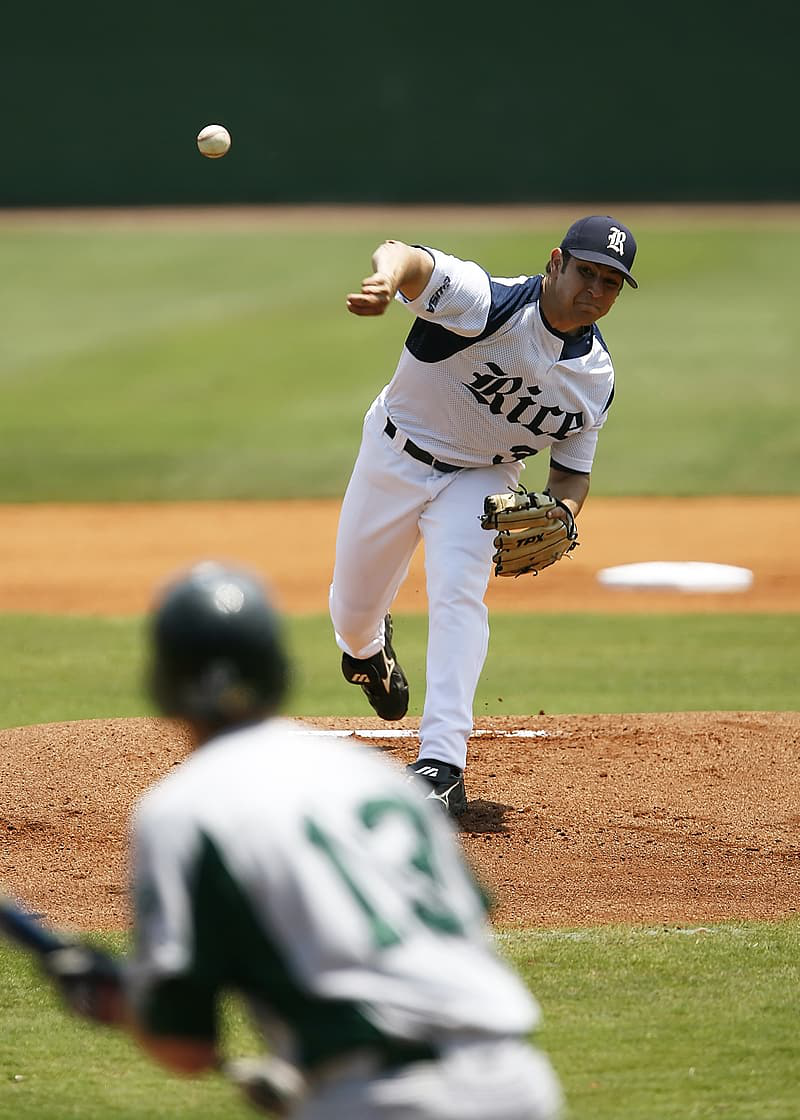

In [ ]:
def load_to_np_string(image_path):
    with open(image_path, 'rb') as f:
        np_image_string = np.array([f.read()])
    image = Image.open(image_path)
    width, height = image.size
    np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)
    return height, width, image, np_image, np_image_string

!wget -q -O test.jpg https://p0.pikrepo.com/preview/342/372/baseball-players-on-field-during-daytime.jpg

image_path = 'test.jpg'
height, width, image, np_image, np_image_string = load_to_np_string(image_path)
image

## Create a Tensorflow session
Now let us create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.

In [ ]:
session = tf.compat.v1.Session(graph=tf.Graph())

# Load the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket. 

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850'
_ = tf.compat.v1.saved_model.loader.load(session, ['serve'], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from gs://cloud-tpu-checkpoints/mask-rcnn/1555659850/variables/variables


## Perform instance segmentation and retrieve the predictions
Now let's run the inference and process the predictions from the model.


In [ ]:
def mask_rcnn(np_image_string):
    num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
        ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
        feed_dict={'Placeholder:0': np_image_string})

    num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
    detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
    detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
    detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
    instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
    ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
    processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
    segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)
    return (num_detections, detection_boxes, detection_scores, detection_classes, instance_masks,
            ymin, xmin, ymax, xmax, processed_boxes, segmentations)

(num_detections, detection_boxes, detection_scores, detection_classes,
 instance_masks, ymin, xmin, ymax, xmax, processed_boxes, segmentations) = mask_rcnn(np_image_string)

## Visualize the detection results
Time to check out the result!

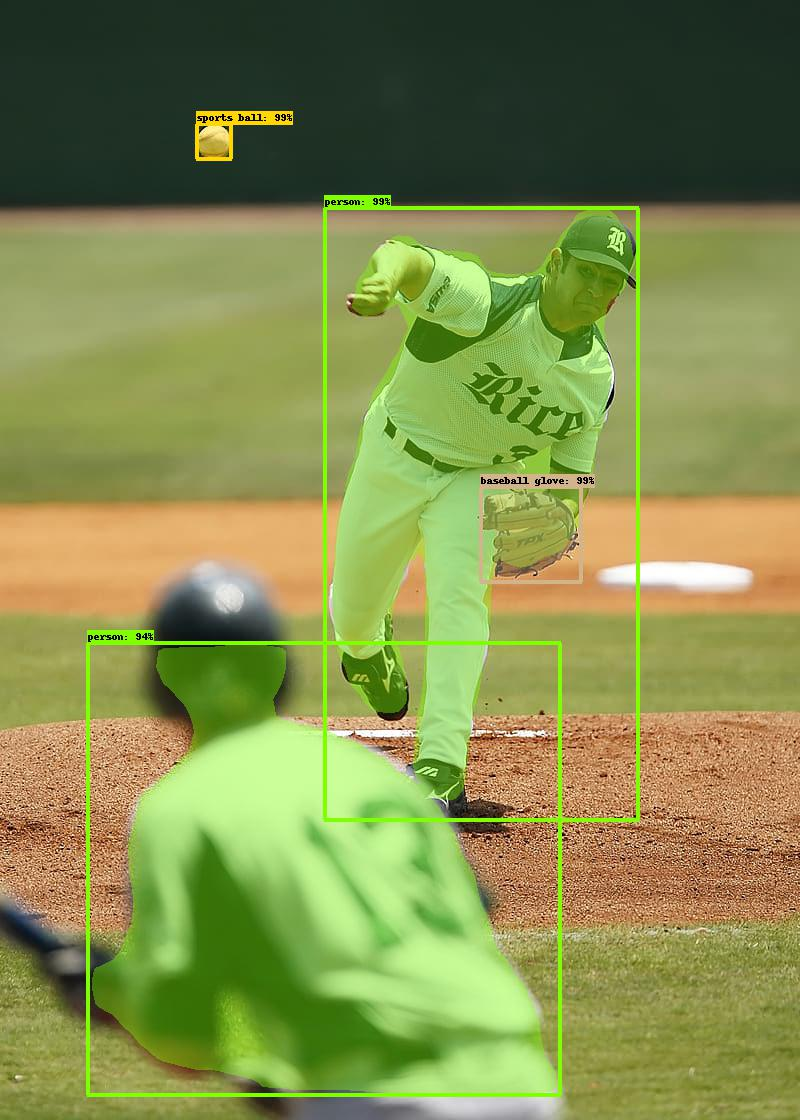

In [ ]:
max_boxes_to_draw = 50   #@param {type:"integer"}
min_score_thresh = 0.5    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)

output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

# Separando una porción de la imagen para su estilización

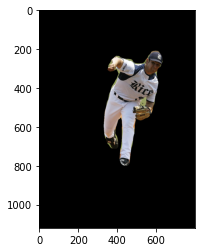

In [ ]:
image = np.asarray(image)
mask = segmentations[0]
mask = np.array([mask, mask, mask])
mask = np.moveaxis(mask, 0, -1)
masked = image * mask
masked = Image.fromarray(masked)
masked.save('masked.png')

%matplotlib inline
plt.imshow(masked)
plt.show()

In [ ]:
# Librería estándar
import os
import time
import random

# Librerías de terceros
import IPython.display
from tensorflow.keras import models 
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_file
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Crea el directorio ./style/
style_imgs_dir = './style/'
if not os.path.exists(style_imgs_dir):
    os.makedirs(style_imgs_dir)

# Descarga las imágenes de prueba en el directorio ./style/
!wget -q -O $style_imgs_dir/starry.jpg https://upload.wikimedia.org/wikipedia/commons/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [ ]:
def load_to_batch(path):
    """Carga una imagen y la retorna en un batch.
    
    Carga la imagen ubicada en path, la redimensiona y
    devuelve un batch conteniendo la imagen. La imagen es
    redimensionada tal que su dimensión más grande (ancho o
    alto) sea de tamaño 512, y se mantenga la relación de
    aspecto original.
    
    Argumentos:
        path: La ubicación de la imagen a leer.

    Retorna:
        Un arreglo numpy de tamaño (1, w, h, n), donde w y h
        son las dimensiones de la imagen luego de redimensionarla
        y n es el número de canales de la imagen.
    """
    # Lee y redimensiona la imagen
    max_dim = 512
    img = Image.open(path)
    long_dim = max(img.size)
    scale = max_dim/long_dim
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)),
                     Image.ANTIALIAS)
    img = img_to_array(img)
    # Incluye la imagen redimensionada dentro de un batch
    img = np.expand_dims(img, axis=0)
    return img.astype('uint8')

def imshow(img, title=None):
    """Muestra una imagen usando matplotlib.
    
    Argumentos:
        img: La imagen a mostrar.
        title (opcional): El título que se desea mostrar.
    """
    # Elimina la primera dimensión para que se tenga
    # solamente una imagen y ya no un batch de una imagen.
    out = np.squeeze(img, axis=0)
    # Muestra la imagen
    out = out.astype('uint8')
    plt.imshow(out)
    plt.axis('off')
    if title:
        plt.title(title)

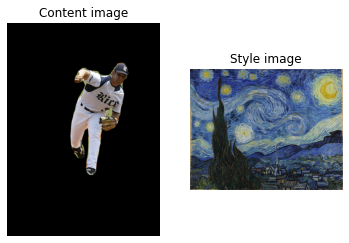

In [ ]:
# Ubicación de la imagen de estilo
style_path = './style/starry.jpg'
# Ubicación de la imagen de contenido
content_path = 'masked.png'

# Lee las imágenes
style_img = load_to_batch(style_path)
content_img = load_to_batch(content_path)

# Muestra las imágenes
plt.subplot(1, 2, 1)
imshow(content_img, 'Content image')
plt.subplot(1, 2, 2)
imshow(style_img, 'Style image')

# Guarda la figura
plt.savefig('src_starry_test.png', bbox_inches='tight')

In [ ]:
def load_and_process(path):
    """Preprocesa una imagen
    
    Carga la imagen ubicada en path, la redimensiona y
    obtiene un batch conteniendo la imagen, usando la
    función load_to_batch. Luego, se le aplica el
    preprocesamiento correspondiente a la red VGG19.

    Argumentos:
        path: La ubicación de la imagen a preprocesar.

    Retorna:
        Un arreglo numpy de tamaño (1, w, h, n) preprocesado,
        donde w y h son las dimensiones de la imagen luego de
        redimensionarla y n es el número de canales de la imagen.
    """
    img = load_to_batch(path)
    img = vgg19.preprocess_input(img)
    return img

In [ ]:
def deprocess_img(processed_img):
    """Aplica el proceso inverso de la función load_and_process.
    
    Argumentos:
        processed_img: una imagen procesada por load_and_process.
                       Puede tener tamaño (1, h, w, n) o (h, w, n).

    Retorna:
        La imagen deprocesada en un arreglo numpy de tipo uint8.
    """
    x = processed_img.copy()
    # Primero se debe asegurar que la imagen tiene
    # las dimensiones correctas
    if x.ndim == 4:
        x = np.squeeze(x, 0)
    assert x.ndim == 3, ('Input to deprocess image must '
                         'be an image of shape '
                         '[1, height, width, channel] '
                         'or [height, width, channel]')
    # Realiza el deprocesamiento
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    # La imagen deprocesada debe ser de tipo uint8
    # por lo que toma valores entre 0 y 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# La capa empleada para obtener el contenido de una imagen
content_layers = ['block5_conv2']

# Las capas empleadas para obtener el estilo de una imagen
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1']

# Constantes auxiliares
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def get_model():
    """Crea el modelo VGG19 con acceso a las capas intermedias deseadas.

    Retorna:
        Un modelo de Keras que acepta como entrada una imagen y retorna
        los feature volumes generados en las capas de estilo y contenido.
    """

    # Carga la red VGG19, entrenada con ImageNet
    # No incluye la parte densa de la red
    vgg = vgg19.VGG19(include_top=False)
    vgg.trainable = False

    # Define las salidas del modelo
    style_outputs = [vgg.get_layer(name).output 
                     for name in style_layers]
    content_outputs = [vgg.get_layer(name).output 
                       for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    # Retorna el modelo
    return models.Model(vgg.input, model_outputs)

In [ ]:
def get_content_loss(base_content, target):
    """Calcula la pérdida de contenido, dadas las
    representaciones de contenido de la imagen objetivo
    y la imagen base.
    
    Argumentos:
        base_content: Representación de contenido de la imagen base.
        target: Representación de contenido de la imagen objetivo.
    Retorna:
        La pérdida de contenido. Se calcula usando la media
        en lugar de simplemente la suma.
    """
    return tf.reduce_mean(tf.square(base_content - target))

In [ ]:
def gram_matrix(input_tensor):
    """Calcula la matriz de Gram de un feature volume.
    
    Argumentos:
        input_tensor: El feature volume generado por la red
                      al recibir como entrada una imagen
    Retorna:
        La matriz de Gram calculada.
    """
    # La cantidad de canales de la imagen
    channels = int(input_tensor.shape[-1])
    # Se vectorizan los feature maps
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    # Se calcula la matriz de Gram como todas las
    # posibles correlaciones entre los feature maps
    # vectorizados.
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [ ]:
def get_style_loss(base_style, gram_target):
    """Calcula la pérdida de estilo

    Argumentos:
        base_style: Un feature volume generado con la imagen de estilo.
        gram_target: Una matriz de Gram de la imagen objetivo.

    Retorna:
        La pérdida de estilo calculada.
    """
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    # En este caso, se omite el término de normalización
    return tf.reduce_mean(tf.square(gram_style - gram_target))
    # / (4. * (channels ** 2) * (width * height) ** 2)

In [ ]:
def get_feature_representations(model, content_path, style_path):
    """Calcula los feature volumes de estilo y contenido deseados.
    
    Carga y preprocesa las imágenes de estilo y contenido, las entrega
    a la red y obtiene las salidas de las capas intermedias de la red
    definidas para el estilo y contenido.

    Argumentos:
        model: El modelo (red) del cual se obtienen las represenaciones.
        content_path: La ubicación de la imagen de contenido.
        style_path: La ubicación de la imagen de estilo.

    Retorna:
        Los feature volumes de estilo y contenido que se desean combinar.
    """
    # Carga las imágenes
    content_image = load_and_process(content_path)
    style_image = load_and_process(style_path)

    # Obtiene los feature volumes de interés
    style_outputs = model(style_image)
    content_outputs = model(content_image)


    # Extrae los feature volumes de estilo y contenido
    style_features = [style_layer[0] 
                      for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] 
                        for content_layer 
                        in content_outputs[num_style_layers:]]
    return style_features, content_features

In [ ]:
def compute_loss(model, loss_weights, init_image,
                 gram_style_features, content_features):
    """Calcula la pérdida total.

    Argumentos:
        model: El modelo con acceso a capas intermedias.
        loss_weights: Los pesos de las contribuciones de las pérdidas
                      de estilo y de contenido a la pérdida total.
        init_image: La imagen x base que se modificará para que minimice
                    la pérdida total.
        gram_style_features: Las matrices de gram de las capas de estilo
                             definidas anteriormente.
        content_features: Los feature volumes obtenidos en las capas de
                          contenido.
        
    Retorna:
        La pérdida total, la pérdida de estilo y la pérdida de contenido.
    """

    style_weight, content_weight = loss_weights

    # Se pasa la imagen por la red para obtener los feature volumes
    # de estilo y contenido.
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Para cada capa de estilo, acumula su contribución
    # en la pérdida de estilo total. En este caso, se decidió
    # que la contribución de cada capa de estilo sea la misma.
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features,
                                        style_output_features):
        style_score += (weight_per_style_layer
                        * get_style_loss(comb_style[0],
                                         target_style))

    # Para cada capa de contenido, acumula su contribución
    # en la pérdida de contenido total.
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, 
                                            content_output_features):
        content_score += (weight_per_content_layer
                          * get_content_loss(comb_content[0],
                                             target_content))

    # Cada pérdida parcial se multiplica por su respectivo peso
    style_score *= style_weight
    content_score *= content_weight

    # Calcula la pérdida total
    loss = style_score + content_score

    # Retorna las pérdidas
    return loss, style_score, content_score

In [ ]:
def compute_grads(cfg):
    # Calcula las pérdidas
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    # Obtiene la pérdida total
    total_loss = all_loss[0]
    # Calcula los gradientes respecto a la imagen combinada x
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [ ]:
def path_to_name(path):
    path = path.split('.')[-2]
    path = path.split('/')[-1]
    return path

In [ ]:
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2,
                       save_as=None):
    # Se carga el modelo. Se debe indicar que no se va a entrenar.
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
    
    # Obtiene los feature volumes de contenido y estilo
    (style_features,
     content_features) = get_feature_representations(model,
                                                     content_path,
                                                     style_path)

    # Calcula las representaciones de estilo
    gram_style_features = [gram_matrix(style_feature)
                           for style_feature
                           in style_features]
    
    # Crea la imagen inicial, que es igual a la imagen de contenido
    init_image = load_and_process(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)

    # Inicializa el optimizador
    opt = Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    # Contador de iteraciones
    iter_count = 1
    
    # Guarda la mejor pérdida y la imagen que genera esa pérdida
    best_loss, best_img = float('inf'), None
    
    # Diccionario que contiene las entradas de la
    # función compute_loss
    loss_weights = (style_weight, content_weight)
    cfg = {'model': model,
           'loss_weights': loss_weights,
           'init_image': init_image,
           'gram_style_features': gram_style_features,
           'content_features': content_features}
        
    # Preparando variables auxiliares para mostrar los resultados
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means     
    
    # Lista para guardar las imágenes generadas en ciertas iteraciones
    imgs = []
    # Listas para guardar el historial de pérdidas
    loss_history = []
    style_loss_history = []
    content_loss_history = []

    # Bucle principal
    for i in range(num_iterations):
        # Halla los gradientes y pérdidas
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        # Se guardan en el historial
        loss_history.append(loss)
        style_loss_history.append(style_score)
        content_loss_history.append(content_score)
        # Aplica la optimización a la imagen
        opt.apply_gradients([(grads, init_image)])
        # La imagen generada debe tener sus valores en el rango válido
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
        
        # Si el nuevo loss es menor al mejor loss
        if loss < best_loss:
            # Actualiza la mejor imagen y el mejor loss
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        # Cada cierto intervalo se muestran los resultados parciales
        if i % display_interval== 0:
            start_time = time.time()
            
            # Se deprocesa la imagen para poder mostrarla
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append((i, plot_img))
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))                
            print(f'Total loss: {loss:.4e}, ' 
                  f'style loss: {style_score:.4e}, '
                  f'content loss: {content_score:.4e}, '
                  f'time: {time.time() - start_time:.4f}s')
    
    # Muestra el tiempo total de optimización
    print('Total time: {:.4f}s'.format(time.time() - global_start))

    # Se muestra el historial de pérdidas
    plt.figure(figsize=(5, 3.5))
    plt.plot(loss_history, label='total')
    plt.plot(style_loss_history, label='style')
    plt.plot(content_loss_history, label='content')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'{path_to_name(content_path)}_{path_to_name(style_path)}_loss.png')

    # Se muestran todos los resultados parciales
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i, (iteration, img) in enumerate(imgs):
            plt.subplot(num_rows,num_cols,i+1)
            plt.imshow(img)
            plt.title(f'Iteration {iteration}')
            plt.axis('off')
            if save_as is not None:
                    plt.savefig(save_as)

    return best_img, best_loss

In [ ]:
def show_results(best_img, content_path, style_path,
                 show_large_final=True, save_as=None):
    # Su funcionamiento es obvio a partir del código
    plt.figure(figsize=(10, 5))
    content = load_to_batch(content_path) 
    style = load_to_batch(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.axis('off')
    
    if save_as is not None:
        plt.savefig(save_as)

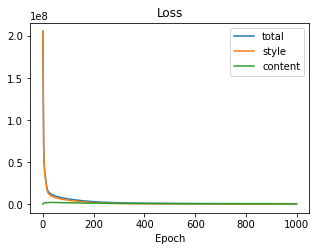

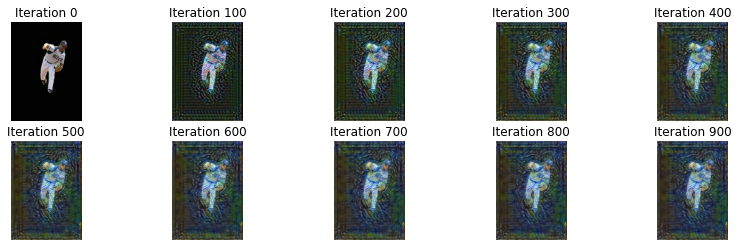

In [ ]:
style_path = 'style/starry.jpg'
content_path = 'masked.png'

best, best_loss = run_style_transfer(content_path,
                                     style_path,
                                     num_iterations=1000,
                                     save_as='stylization.png')

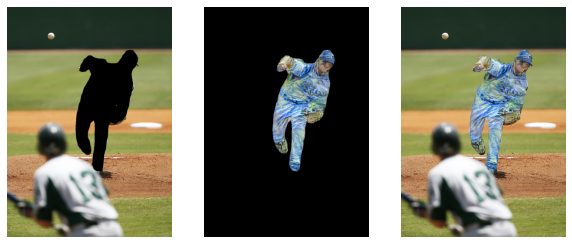

In [ ]:
best_img = Image.fromarray(best).resize((width, height))

background = image * np.logical_not(mask)
foreground = best_img * mask
total = background + foreground

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(background)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(foreground)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(total)
plt.axis('off');

In [ ]:
Image.fromarray(foreground).save('stylized_segment.png')
Image.fromarray(total).save('stylized_segment_on_bg.png')

In [ ]:
# Crea el directorio ./style/
style_imgs_dir = './style/'
if not os.path.exists(style_imgs_dir):
    os.makedirs(style_imgs_dir)

# Descarga las imágenes de estilo en el directorio ./style/
!wget -q -O $style_imgs_dir/1.png https://upload.wikimedia.org/wikipedia/commons/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
!wget -q -O $style_imgs_dir/2.png https://img.theculturetrip.com/1024x/smart/wp-content/uploads/2017/10/monet_water_lilies_1916.jpg
!wget -q -O $style_imgs_dir/3.png https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Johannes_Vermeer_%281632-1675%29_-_The_Girl_With_The_Pearl_Earring_%281665%29.jpg/1200px-Johannes_Vermeer_%281632-1675%29_-_The_Girl_With_The_Pearl_Earring_%281665%29.jpg
!wget -q -O $style_imgs_dir/4.png https://www.vangoghstudio.com//Files/6/102000/102147/ProductPhotos/Source/1231095862.jpg

style_imgs_paths = [os.path.join(style_imgs_dir, style_img)
                    for style_img in os.listdir(style_imgs_dir)]

In [ ]:
# !wget -q -O test.jpg https://p0.pikrepo.com/preview/342/372/baseball-players-on-field-during-daytime.jpg
# !wget -q -O test.jpg https://upload.wikimedia.org/wikipedia/commons/0/0c/Mark_Sanford_%28basketball%29_02.jpg
!wget -q -O test.jpg https://i.pinimg.com/474x/ed/89/47/ed8947fe0834327f61985a312f094210.jpg

image_path = 'test.jpg'
height, width, image, np_image, np_image_string = load_to_np_string(image_path)

(num_detections, detection_boxes, detection_scores, detection_classes,
 instance_masks, ymin, xmin, ymax, xmax, processed_boxes, segmentations) = mask_rcnn(np_image_string)

image = np.asarray(image)

In [ ]:
valid_detections = (detection_scores > 0.5) & (detection_classes == 1)
valid_segmentations = segmentations[valid_detections]

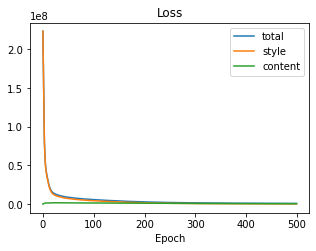

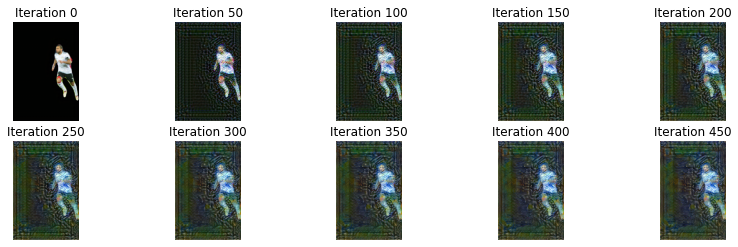

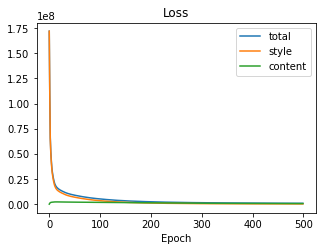

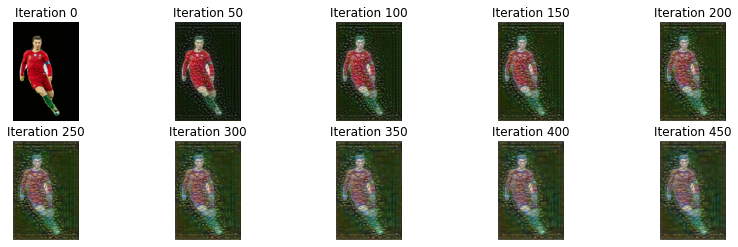

In [ ]:
result = image.copy()
style_imgs = random.choices(style_imgs_paths, k=len(valid_segmentations))

stylized_segments = []
for segmentation, style_path in zip(valid_segmentations, style_imgs):
    mask = segmentation
    mask = np.array([mask, mask, mask])
    mask = np.moveaxis(mask, 0, -1)
    result *= np.logical_not(mask)
    masked = image * mask
    masked = Image.fromarray(masked)
    content_path = 'masked.png'
    masked.save(content_path)
    best, _ = run_style_transfer(content_path,
                                 style_path,
                                 num_iterations=500)
    best = Image.fromarray(best)
    best = best.resize((width, height))
    stylized_segments.append(best)

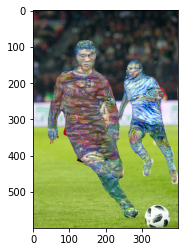

In [ ]:
final = result

for i, (stylized_segment, mask) in enumerate(zip(stylized_segments,
                                                 valid_segmentations)):
    stylized_segment.save(f'stylized_segment_{i}.png')
    mask = np.array([mask, mask, mask])
    mask = np.moveaxis(mask, 0, -1)
    final += mask * stylized_segment

plt.imshow(final)
Image.fromarray(final).save('total.png')